In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import matplotlib.lines as mlines

# import logging
# import pprint
import os
import re
import math
import time
import timeit

# from IPython.display import Audio
# from IPython.core.display import display
import sounddevice as sd
from scipy.io import wavfile

# import warnings
# warnings.filterwarnings("ignore")

# from music21 import converter, corpus, instrument, midi, note, chord, pitch, roman, stream
# import mido
# from mido import Message, MidiFile, MidiTrack

In [2]:
sd.query_devices()

> 0 MacBook Air Microphone, Core Audio (1 in, 0 out)
< 1 MacBook Air Speakers, Core Audio (0 in, 2 out)
  2 ZoomAudioDevice, Core Audio (2 in, 2 out)

### Function to create file

In [3]:
def midi_to_timeseries(midiPath):
    """ Function that converts .txt file with midi events* to a list and returns all note on events.
    
    Args:
        midiPath: file path - .txt file with all note and pedal events of form [t,event,note/pedal,vel]
    
    Returns:
        time_notes: list of the form[[t,note,vel],[t,note,vel],[t,note,vel],...]
    
    """

    #    MIDI EVENT TYPES
    #    0x80 (hex)      128 (decimal)    Note Off
    #    0x90 (hex)      144 (decimal)    Note On
    #    0xB0 (hex)      176 (decimal)    Continuous Controller
    
    time_notes = []
    uniqueTypes = [128,144,176] 
            
    with open(midiPath) as midi_events:
        for line in midi_events:
            processedLine = line.split(" ")
    
            processedLine[0] = int(processedLine[0]) # processedLine[0] is timestamp
            processedLine[1] = int(processedLine[1], 16) # processedLine[1] is event type
            processedLine[2] = int(processedLine[2], 16) # processedLine[2] is note
            processedLine[3] = int(processedLine[3],16) # processedLine[3] is velocity

            if processedLine[1] not in uniqueTypes:
                print("unexpected event type got! ", processedLine[1])

            if processedLine[1] == 144:
                time_notes.append([processedLine[0], processedLine[2], processedLine[3]])
                
    return time_notes

### Function to read .wav file

In [4]:
def read_audio(file):
    """ Function that reads .wav file of midi recording and saves it to a global variable
    Args:
        file: .txt file with midi notes
    """
    
    global samplerate, piano_audio
    samplerate, piano_audio = wavfile.read(file)

read_audio('Audio.wav')

/var/folders/f5/4s_l2s456y985n42_18zrt_00000gn/T/ipykernel_47044/2785934704.py:8: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, piano_audio = wavfile.read(file)


### Functions to deal with notes as integers vs names

In [5]:
def int_to_note(i):
    """ Function that converts note from integer to name
    Args:
        i: integer value corresponding to note
    Returns:
        note: note name, eg. "C4" 
    """
    
    # convert integer to note
    notes = ['C','C#/Db','D','D#/Eb','E','F','F#/Gb','G','G#/Ab','A','A#/Bb','B']
    return notes[i%12] + str(i//12 - 1)

def note_to_int(note):
    """ Function that converts note from name to integer
    Args:
        note: note name, eg. "C4"
    Returns:
        i: integer value corresponding to note
    """
    
    # convert integer to note
    temp = re.compile("([a-zA-Z]+)([0-9]+)")
    note = temp.match(note).groups()
    notes = {'C':0,'C#/Db':1,'C#':1,'Db':1,'D':2,'D#/Eb':3,'D#':3,'Eb':3,'E':4,'F':5,'F#/Gb':6,'F#':6,'Gb':6,'G':7,'G#/Ab':8,'Ab':8,'G#':8,'A':9,'A#/Bb':10,'A#':10,'Bb':10,'B':11}
    return notes[note[0]] + 12*(int(note[1])+1)


### Functions to help judge quality of match

In [66]:
def predict(notes, source_id_start, source_id_end, target_id_start, target_id_end, curr_time,pred_time=100,sound=False):
    """ Function that predicts the next 100 ms given a match
    Args:
        notes: 
        source_id_start: 
        source_id_end: 
        target_id_start: 
        target_id_end: 
        curr_time: 
        
    Returns:
        pred: predicted notes for 100ms, [[predTime1, note1, vel1], [predTime2, note2, vel2],...]
    """
    
    # predicting pred_time(100ms) of music
    target_time = notes[target_id_start][0]
    time = target_time
    predicted = [target_id_start]
    i = target_id_start + 10
    while time <= target_time + pred_time:
        if notes[i][0] < time:
            predicted.append(i)
            i += 1
        time += 10
    predicted.append(i)
        
    if(sound):
        play_match(notes[source_id_start][0],notes[source_id_end][0],notes[predicted[-1]][0],notes[predicted[0]][0],pausebetween=False)
        
    return predicted
    
def display_match(notes, source_id_start, source_id_end, target_id_start, target_id_end, score, sourceStart, targetStart):
    """ Function that displays the snippets if they match.
    Args:
        notes: note name, eg. "C4"
        source_start: 
        source_end: 
        target_start: 
        target_end: 
        score: 
        sourceStart: 
        targetStart: 
    """
    
    print("Score: ", score)
    print("Source({st}):  Target({tt}): ".format(st=source_id_end, tt=target_id_end))
    for i in range(min(source_id_start-source_id_end, target_id_start-target_id_end)):
        print(notes[i+source_id_end][0]-sourceStart, int_to_note(notes[i+source_id_end][1]), end=", ")
        print(notes[i+target_id_end][0]-targetStart, int_to_note(notes[i+target_id_end][1]))
    for i in range(target_id_start-target_id_end, source_id_start-source_id_end):
        print(notes[i+source_id_end][0]-sourceStart, int_to_note(notes[i+source_id_end][1]), end=", \n")
    for i in range(source_id_start-source_id_end, target_id_start-target_id_end):
        print("        ,",notes[i+target_id_end][0]-targetStart, int_to_note(notes[i+target_id_end][1]))
        
    print("  Next notes: ")
    for i in range(5):
        print(notes[i+source_id_start][0]-sourceStart,int_to_note(notes[i+source_id_start][1]), end=", ")
        print(notes[i+target_id_start][0]-targetStart,int_to_note(notes[i+target_id_start][1]))
        
    print()
        
def play_match(source_start, source_end, target_start, target_end, pausebetween=False):
    """ Function that plays portion of audio file corresponding to each sequence of a match
    Args:
        source_start: 
        source_end: 
        target_start: 
        target_end: 
    """
    
    global piano_audio
    ss = source_start * samplerate // 1000
    se = source_end * samplerate // 1000
    te = target_end * samplerate // 1000
    ts = target_start * samplerate // 1000
    #Source
    sd.play(piano_audio[se:ss], samplerate, blocking = True)
    if pausebetween:
        time.sleep(1)
    #Target
    sd.play(piano_audio[te:ts], samplerate, blocking = True)
    if pausebetween:
        time.sleep(1)

### Functions to calculate similarity

In [7]:
def musical_similarity(tf1, tf2, disp = False):
    """ Function that calculates similarity score between 2 snippets 
        eg [[-17,60],[-100,62],[-101,64],[-300,60]] and [[-20,60],[-50,61],[-101,64],[-102,62],[-307,60]]
    
    Args:
        tf1: first snippet [[t,note,vel],[t,note,vel],[t,note,vel],...]
        tf2: second snippet [[t,note,vel],[t,note,vel],[t,note,vel],...]
    
    Returns:
        score: similarity - integer between 0 to 1
    
    """
    # updating time stamps wrt first note for tf1
    sequence1 = []
    first = tf1[0] # Timestamp of first note
    for el in tf1: # Save time delta of each note in sequence (relative to first note)
        sequence1.append([el[0]-first[0],el[1]])
    
    seq_1_time_del = (tf1[-1][0] - first[0]) * 1.0
        
    # updating time stamps wrt first note for tf2
    sequence2 = []
    first = tf2[0]
    for el in tf2:
        sequence2.append([el[0]-first[0],el[1]])
        
    seq_2_time_del = tf2[-1][0] - first[0]
        
    time_ratio = seq_2_time_del / seq_1_time_del
        
    # Calculating score array by comparing every note from each sequence and taking the best match
    score = []
    for event1 in range(len(sequence1)):
        max_score = 0 # score for best match with event1
        max_el = -1 # note index of best match
        for event2 in range(len(sequence2)):
            s = note_similarity(sequence1[event1],sequence2[event2],time_ratio)
            if s > max_score:
                max_score = s
                max_el = event2
                
        # If we get a non-zero similarity score, we assume that the
        # two notes "match", and remove them from the potential match
        # pool
        if max_score != 0: # if match found
            score.append(max_score)
            sequence1[event1] = [] # setting to empty because a match for this note has already been found
            sequence2[max_el] = []
                
    # For every pair of notes in both sequences, if a match was not found, add a zero score
    for i in range((len(sequence1) + len(sequence2) - (2*len(score)))//2):
        score.append(0)
    
    if disp:
        print("Scores:",score)
       
    # Similarity of the two sequences is the mean of the note similarity scores
    score = np.mean(score)
    
    # including length in score, if at least 5 notes
    if len(tf1)>5:
        score += score * seq_1_time_del/100000 # 10 seconds yield 10% increase
        
    if score>1:
        score = 1
    
    return score
     
def note_similarity(note1,note2,ratio):
    """ Function that calculates similarity score between 2 notes - depending on note value and time
    
    Args:
        note1: first note to compare [t,note,vel]
        note2: second note to compare [t,note,vel]
    
    Returns:
        score: similarity - integer between 0 to 1
    
    """
    # score is linear with time difference between notes
    
    min_dist = 400 * ratio # acceptable time difference for same note
    
    if (not note1) or (not note2):
        return 0
    if note1 == note2: # exact match!
        return 1
    if note1[1] != note2[1]: # different notes
        return 0
    
    # check if acceptable match wrt time - score is linear with time stamp difference
    time_diff = abs(note1[0] - note2[0])
    if  time_diff < min_dist:
        return 1 - time_diff/min_dist
    else:
        return 0
   

### Functions to look at history and call similarity

In [8]:
def calculate_similarity_time(notes, source_id, currTime, max_matches=None, skip = 100, disp=False):
    """ Function that calls musical similarity on targets generated for a source_id.
        Target snips start at every 100 ms, and has same time length as source.
    
    Args:
        notes: list of all notes from a recording [[t,note,vel],[t,note,vel],[t,note,vel],...]
        source_id: indices of note array corresponding to current time snippet (source_id_start>source_id_end) 
                   [source_id_start, source_id_end]
        currTime: time stamp at which we are searching for matches (ms)
        max_matches: optional param to state how many matches to stop after
        disp: boolean whether to print each match (defaults True)
    
    Returns:
        matches: list of matches [[currTime, pastTime1, score1], [currTime, pastTime2, score2],...] 
    
    """
    calcstart = timeit.default_timer()
    matches = []
    last_id_end = 0 # track previous end index of target
    last_id_start = 0
    source_id_start, source_id_end = source_id
    source_end = notes[source_id_end][0] # start and end time stamps of source
    length_ms = currTime - source_end #in milliseconds
    count = 0 # counting num "good" matches
    
    for target_start in range(length_ms, currTime-1500, skip):
#         starttime = timeit.default_timer()
        target_end = target_start - length_ms # pick target_end by time length of course snip
        
        # finding new end index
        for i in range(last_id_end,len(notes)):
            if notes[i][0] >= target_end:
                target_id_end = i
                break
             
        # finding new start index
        for i in range(target_id_end,len(notes)):
            if notes[i][0] > target_start:
                target_id_start = i
                break
                
        if target_id_end == target_id_start:
            continue
#         if target_id_end == last_id_end and last_id_start == target_id_start:
#             continue
            
        score = musical_similarity(notes[source_id_end:source_id_start], notes[target_id_end:target_id_start])
        if score:
            if score>0.7:
                count += 1
                # Dsiplaying matches > 0.7 if disp is True
                if disp:
                    display_match(notes, source_id_start, source_id_end, target_id_start, target_id_end, score, source_end, notes[target_id_end][0])
                    play_match(currTime, source_end, target_start, target_end)
    #                 predict(notes, source_id_start, source_id_end, target_id_start, target_id_end, currTime, target_start)

            matches.append([currTime, target_start, score])
        if max_matches and count > max_matches:
            break
        last_id_end = target_id_end
        last_id_start = target_id_start
#         looptime = timeit.default_timer() - starttime
#         if looptime>0.05:
#             print("LoopTime:",looptime,"target&source:",currTime,target_start)
        
    calctime = timeit.default_timer() - calcstart
    global t_exec
    t_exec.append([currTime,calctime])
#     if calctime>1:
#         print("Time:",calctime,"for source:",currTime,"and length",length_ms,"ms",",score:",matches[:][2])
    if disp:
        time.sleep(5)
    
    return matches


### Functions that calculates matches for every 100ms in track

In [11]:
def get_source_notes_index(notes, start_index, start_time, min_notes, max_notes, min_time):
    """ Function that ...
    
    Args:
        notes: list of all note arrays of lengths min_notes to max_notes snip[1][2][3][4]
               1 - length of snip, 2 - start index from notes, 3 - index of note in array, 4 - [t, note, vel]
        start_index: 
        start_time: start index of notes array - corresponding to current time
        min_notes: min number of notes for a valid sequence, integer
        max_notes: max note length for a snippet, integer
        min_time: min time length for a valid sequence, integer (ms)\
    
    Returns:
        source_id: 
    
    """
    for end_index in range(start_index-min_notes, start_index - max_notes - 1, -1):
        if start_time - notes[end_index][0] >= min_time:
            source_id = [start_index,end_index]
            return source_id
        
    print("Error: Trying to access snippet length > max_notes")
    return None

def get_source_notes(notes, start_time, min_notes, max_notes, min_time):
    """ Function that ...
    
    Args:
        snips: list of all note arrays of lengths min_notes to max_notes snip[1][2][3][4]
               1 - length of snip, 2 - start index from notes, 3 - index of note in array, 4 - [t, note, vel]
        start_time: start index of notes array - corresponding to current time
        min_notes: min number of notes for a valid sequence, integer
        max_notes: max note length for a snippet, integer
        min_time: min time length for a valid sequence, integer (ms)
        offset: used to find note snippets longer than min_length, integer, default=0
    
    Returns:
        matches: list of matches [[currTime, pastTime1, score1], [currTime, pastTime2, score2],...] 
    
    """
    for i in range(len(notes)):
        if notes[i][0] > start_time:
            start_index = i
            break
    else:
        print("Error: Start time too large")
        return None
    
    if start_index<3:
        return None
    
    return get_source_notes_index(notes, start_index, start_time, min_notes, max_notes, min_time)

def find_matches_entire_audio(notes, minNotes, maxNotes, minTime, max_matches, start=0, \
                              skip=100,end=None,thresh=0.7,disp=False):
    """Function that ...
    
    Args:
    
    Returns:
    
    """
    percentage_matches_thresh = 0
    percentage_matches_any = 0
    sims_arr = []
    
    if not end:
        end = notes[-1][0]
        
    for i in range(start, end, skip):
        print("\r",end="")
        print("i:",i,end="   ")
        
        # only calculate on historical timestamps
        offset = 0 # used to increase lenght of snip to find match
        count = notes[-1][0] + 1 # count number of matches better than thresh
        oldtime = minTime
        sim = None
        sourceId = None
        
        while count > max_matches:
            sim_old = sim, sourceId
            sourceId = get_source_notes(notes, i, minNotes, maxNotes, oldtime+offset)
            if not sourceId:
                print("Failed for sourceId = ", sourceId, ", on attempt ", (offset//500))
                break
            oldtime = notes[sourceId[0]][0] - notes[sourceId[1]][0]
            sim = calculate_similarity_time(notes, sourceId, i, disp=disp)
            count = 0
            for match in sim:
                if match[2] > thresh:
                    count += 1
            offset += 500
        
        if count < max_matches and sim_old:
            sim, sourceId = sim_old
        if sourceId and sim:
            matchLength = sourceId[0] - sourceId[1] # in notes
            matchTime = notes[sourceId[0]][0] - notes[sourceId[1]][0] # in time
            percentage_matches_any += 1
            flag = True
            for match in sim:
                match.append(matchLength)
                match.append(matchTime)
                sims_arr.append(match)
                if flag and match[2]>thresh:
                    percentage_matches_thresh += 1
                    flag = False

    percentage_matches_thresh /= ((end-start)/skip)
    percentage_matches_any /= ((end-start)/skip)
    
    return sims_arr,percentage_matches_any,percentage_matches_thresh


### Helper Functions

In [12]:
def time_to_index(notes, timestamp):
    for i in range(len(notes)):
        if notes[i][0] > timestamp:
            return i
        
def index_to_time(notes, index):
    return notes[index][0]

def index_to_sequence(notes, ids): # assume start>end & not include start for convention
    start_id, end_id = ids
    sequence = []
    for i in range(end_id,start_id):
        sequence.appaned(notes[i])
    return sequence

def time_to_sequence(notes, times): # assume start>end & not include start for convention
    start, end = times
    i = time_to_index(notes, end)
    sequence = []
    while i < len(notes):
        if notes[i][0]>=start:
            break
        sequence.append(notes[i])
        i += 1
    return sequence


In [13]:
sd.play(piano_audio, samplerate)

In [14]:
sd.stop()

In [15]:
midiPath = '../midi-recordings/ladispute.txt'
notes = midi_to_timeseries(midiPath)

In [35]:
# calculating similarity

global t_exec
t_exec=[]

minNotes = 8
maxNotes = 60 # max length of snippet to be calculated
minTime = 1500 # min time in ms
maxMatches = 2 # if more matches, increase snippet length
thresh = 0.7
start=175000
skip=minTime
end=500000

sims_arr,perc_any,perc_thresh = find_matches_entire_audio(notes, minNotes, maxNotes, minTime, maxMatches,\
                                                          start=start,skip=skip,end=end,thresh=0.7)

print("\n\nPercentage matches found: ", perc_any)
print("\n\nPercentage matches >",thresh,"found: ", perc_thresh)


i: 209500   Error: Trying to access snippet length > max_notes
Failed for sourceId =  None , on attempt  7
i: 211000   Error: Trying to access snippet length > max_notes
Failed for sourceId =  None , on attempt  7
i: 212500   Error: Trying to access snippet length > max_notes
Failed for sourceId =  None , on attempt  7
i: 214000   Error: Trying to access snippet length > max_notes
Failed for sourceId =  None , on attempt  7
i: 215500   Error: Trying to access snippet length > max_notes
Failed for sourceId =  None , on attempt  7
i: 217000   Error: Trying to access snippet length > max_notes
Failed for sourceId =  None , on attempt  7
i: 218500   Error: Trying to access snippet length > max_notes
Failed for sourceId =  None , on attempt  7
i: 220000   Error: Trying to access snippet length > max_notes
Failed for sourceId =  None , on attempt  7
i: 221500   Error: Trying to access snippet length > max_notes
Failed for sourceId =  None , on attempt  7
i: 223000   Error: Trying to access s

i: 373000   Error: Trying to access snippet length > max_notes
Failed for sourceId =  None , on attempt  1
i: 374500   Error: Trying to access snippet length > max_notes
Failed for sourceId =  None , on attempt  1
i: 376000   Error: Trying to access snippet length > max_notes
Failed for sourceId =  None , on attempt  1
i: 377500   Error: Trying to access snippet length > max_notes
Failed for sourceId =  None , on attempt  1
i: 379000   Error: Trying to access snippet length > max_notes
Failed for sourceId =  None , on attempt  1
i: 380500   Error: Trying to access snippet length > max_notes
Failed for sourceId =  None , on attempt  1
i: 382000   Error: Trying to access snippet length > max_notes
Failed for sourceId =  None , on attempt  1
i: 383500   Error: Trying to access snippet length > max_notes
Failed for sourceId =  None , on attempt  1
i: 499000   

Percentage matches found:  0.3738461538461539


Percentage matches > 0.7 found:  0.3738461538461539


In [36]:
# choosing only significant scores and storing the new data in sims_plot
sims_arr = np.array(sims_arr)
sims_thresh = sims_arr * (sims_arr>thresh) # considering a match if score greater than a threshold
# sims_plot

simsDF = pd.DataFrame(data=sims_thresh, columns=['source_timestamp', 'target_timestamp','score','match_len','match_time'])
simsDFall = pd.DataFrame(data=sims_arr, columns=['source_timestamp', 'target_timestamp','score','match_len','match_time'])


<AxesSubplot:title={'center':'All matches >0.7, for \nMin Snippet Length=8 notes, Max matches=2'}, xlabel='source_timestamp', ylabel='target_timestamp'>

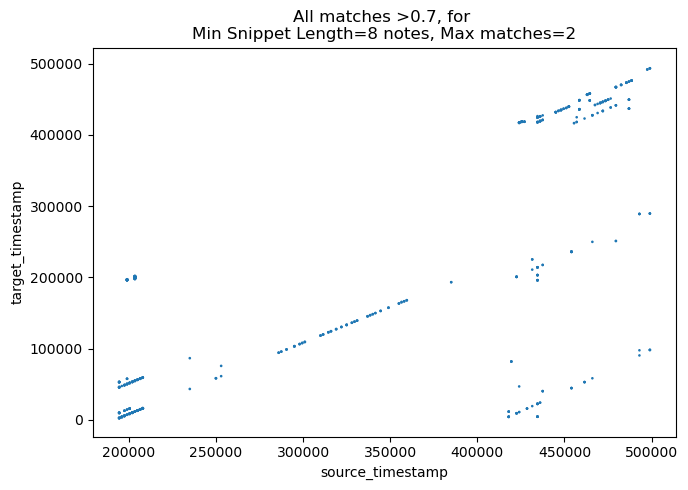

In [37]:
# plotting all mathes > threshold score

plt.rcParams["figure.figsize"] = [7, 5]
plt.rcParams["figure.autolayout"] = True

title = "All matches >"+str(thresh)+", for \nMin Snippet Length=" + str(minNotes) + " notes, Max matches=" + str(maxMatches)
simsDF.plot.scatter(x="source_timestamp", y="target_timestamp", s='score', title=title)


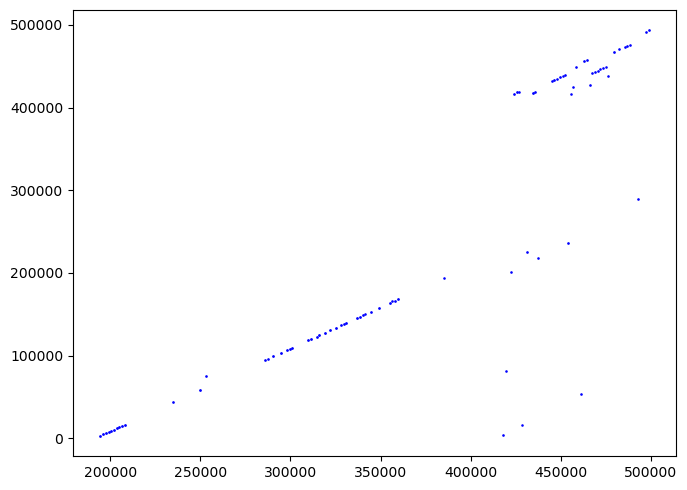

In [46]:
# Plotting best match only

plt.rcParams["figure.figsize"] = [7, 5]
plt.rcParams["figure.autolayout"] = True

count = 0
for x in range(minTime, notes[-1][0], 500):
    y = simsDFall.loc[simsDFall['source_timestamp'] == x]['score']
    if y.any(): 
        y = y.idxmax()
    else:
#         print("No match for",x)
        continue
    plt.scatter(simsDFall['source_timestamp'].loc[y],simsDFall['target_timestamp'].loc[y],simsDFall['score'].loc[y],c='blue')
    
plt.show()

1375


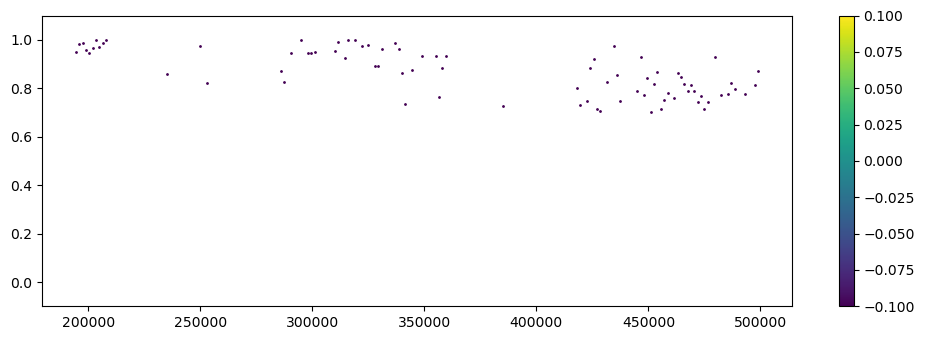

In [45]:
# Plotting best match score 

plt.rcParams["figure.figsize"] = [10, 3.50]
plt.rcParams["figure.autolayout"] = True

count = 0
for x in range(minTime, notes[-1][0], 500):
    y = simsDFall.loc[simsDFall['source_timestamp'] == x]['score'].max()
    s = simsDFall.loc[(simsDFall['source_timestamp'] == x) & (simsDFall['score'] == y)]['match_len'].max()
#     print(s)
    if math.isnan(y):
        count += 1
        y = 0
    plt.scatter(x,y,1,c=s,cmap='viridis') # need to include s (len of best match)
    
print(count)
plt.ylim(-0.1, 1.1)
plt.colorbar()
plt.show()

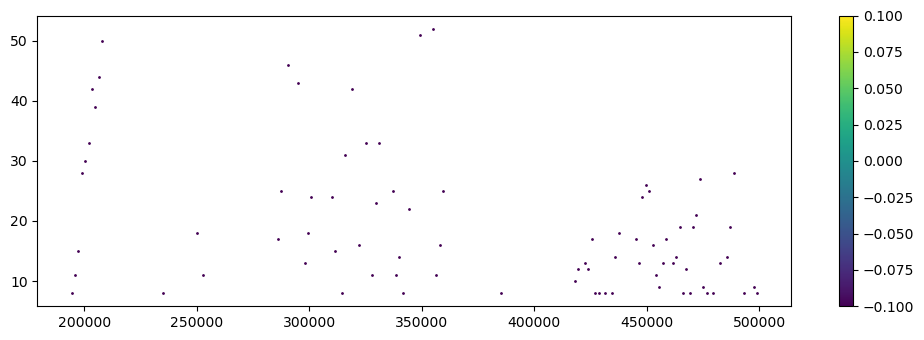

In [47]:
# Plotting note length of best match  

plt.rcParams["figure.figsize"] = [10, 3.50]
plt.rcParams["figure.autolayout"] = True

count = 0
for x in range(minTime, notes[-1][0], 500):
    y = simsDFall.loc[simsDFall['source_timestamp'] == x]['score'].max()
    s = simsDFall.loc[(simsDFall['source_timestamp'] == x) & (simsDFall['score'] == y)]['match_len'].max()
#     print(s)
    if math.isnan(y):
        count += 1
        y = 0
    plt.scatter(x,s,1,c=y,cmap='viridis') # need to include s (len of best match)
    
# print(count)
# plt.ylim(-0.1, 1.1)
plt.colorbar()
plt.show()

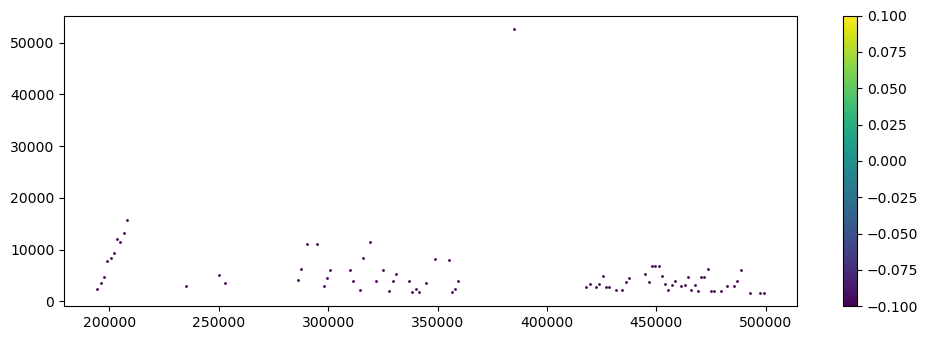

In [48]:
# Plotting time length of best match  

plt.rcParams["figure.figsize"] = [10, 3.50]
plt.rcParams["figure.autolayout"] = True

count = 0
for x in range(minTime, notes[-1][0], 500):
    y = simsDFall.loc[simsDFall['source_timestamp'] == x]['score'].max()
    s = simsDFall.loc[(simsDFall['source_timestamp'] == x) & (simsDFall['score'] == y)]['match_time'].max()
#     print(s)
    if math.isnan(y):
        count += 1
        y = 0
    plt.scatter(x,s,1,c=y,cmap='viridis') # need to include s (len of best match)
    
# print(count)
# plt.ylim(-0.1, 1.1)
plt.colorbar()
plt.show()

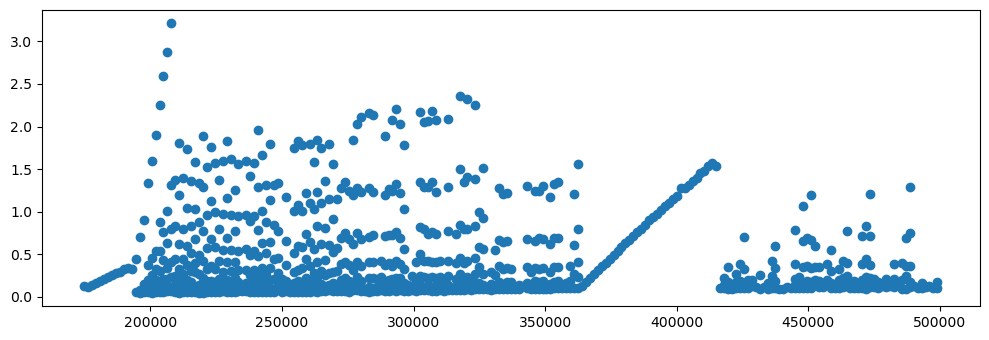

In [42]:
t_exec = np.array(t_exec)
plt.scatter(t_exec[:,0],t_exec[:,1])
plt.show()

### Testing for 5 second snippets
#### Testing musical_similarity

In [70]:
# 1. Zulip example to test similarity score
tf1 = [[-17,60],[-100,62],[-101,64],[-300,60]]
tf2 = [[-20,60],[-50,61],[-101,64],[-102,62],[-307,60]]

musical_similarity(tf1,tf2)

0.9950696864111499

In [69]:
# x ms of all playthroughs of La Dispute
x = 5000
t1 = [x,0] # timestamps in ms
t2 = [191000+x,191000]
t3 = [413000+x,413000]
t4 = [587000+x,587000]

tf1 = time_to_sequence(notes, t1)
tf2 = time_to_sequence(notes, t2)
tf3 = time_to_sequence(notes, t3)
tf4 = time_to_sequence(notes, t4)

score = musical_similarity(tf1,tf4,disp=True)
print(score)
display_match(notes, time_to_index(notes,t1[0]),time_to_index(notes,t1[1]),time_to_index(notes,t2[0]),time_to_index(notes,t2[1]), score, t1[0], t2[0])
# play_match(t1[0],t1[1],t2[0],t2[1])
predict(notes, time_to_index(notes,t1[0]), time_to_index(notes,t1[1]), time_to_index(notes,t2[0]),time_to_index(notes,t2[1]), tf1[-1][0],pred_time=100,sound=True)


Scores: [0.9095385278895918, 0.9909538527889592, 0.9487384991374354, 0.9577846463484762, 0.7195694364577343, 0.6894156124209316, 0.8100309085681426, 0.9246154399079931, 0.7798770845313399, 0.8401847326049454, 0.4602465497412306, 0.4391388729154686, 0.7346463484761356, 0.6652925531914893, 0.6894156124209316, 0]
0.7527729718386106
Score:  0.7527729718386106
Source(0):  Target(758): 
-4749 D#/Eb3, -4326 D#/Eb3
-4746 D#/Eb4, -4323 D#/Eb4
-4163 G3, -3732 G3
-4158 A#/Bb3, -3723 A#/Bb3
-3505 A#/Bb3, -3117 A#/Bb3
-3500 G3, -3104 G3
-2932 A#/Bb4, -2551 A#/Bb4
-2928 D#/Eb3, -2539 D#/Eb3
-2363 G3, -1960 G3
-2351 A#/Bb3, -1912 A#/Bb3
-1728 G3, -1319 G3
-1701 A#/Bb3, -856 D#/Eb4
-1262 D#/Eb4, -809 D3
-1190 D3, -770 D4
-1168 D4, -132 B3
-586 B3, -130 G3
-554 G3, 
  Next notes: 
35 G3, 394 B3
59 B3, 397 G3
665 B4, 1053 D3
676 D3, 1056 B4
1271 G3, 1640 B3



[774, 784]

In [226]:
# calculating similarity

global t_exec
t_exec=[]

minNotes = 8
maxNotes = 60 # max length of snippet to be calculated
minTime = 1500 # min time in ms
maxMatches = 2 # if more matches, increase snippet length
thresh = 0.7
start=0
skip=minTime
end=500000

sims_arr,perc_any,perc_thresh = find_matches_entire_audio(notes, minNotes, maxNotes, minTime, maxMatches,\
                                                          start=start,skip=skip,end=end,thresh=0.7)

print("\n\nPercentage matches found: ", perc_any)
print("\n\nPercentage matches >",thresh,"found: ", perc_thresh)


i: 188500   Time: 0.501720166997984 for source: 188500 and length 18995 ms
i: 190000   Time: 0.5358003329965868 for source: 190000 and length 20495 ms
i: 191500   Time: 0.5716886660011369 for source: 191500 and length 21995 ms
i: 193000   Time: 0.5393352080063778 for source: 193000 and length 20664 ms
i: 194500   Time: 0.7528841660023318 for source: 194500 and length 22142 ms
i: 196000   Time: 1.1823514589996194 for source: 196000 and length 23642 ms
i: 197500   Time: 1.5209616249994724 for source: 197500 and length 25142 ms
i: 199000   Time: 0.6335677079987363 for source: 199000 and length 7323 ms
Time: 2.240240332997928 for source: 199000 and length 26642 ms
i: 200500   Time: 0.7573829160028254 for source: 200500 and length 8223 ms
Time: 2.6656098749954253 for source: 200500 and length 28142 ms
i: 202000   Time: 0.5439424159994815 for source: 202000 and length 6770 ms
Time: 0.9145282079989556 for source: 202000 and length 9104 ms
Time: 3.1864177909956197 for source: 202000 and length

i: 238000   Time: 0.8110022499968181 for source: 238000 and length 7949 ms
Time: 1.478256374997727 for source: 238000 and length 10959 ms
Time: 2.3589967919979244 for source: 238000 and length 14105 ms
Error: Trying to access snippet length > max_notes
Failed for source_id =  None , on attempt  7
i: 239500   Time: 0.5150444169994444 for source: 239500 and length 5814 ms
Time: 0.8947299169958569 for source: 239500 and length 8219 ms
Time: 1.6006129590023193 for source: 239500 and length 11220 ms
Time: 2.660069500001555 for source: 239500 and length 14841 ms
Error: Trying to access snippet length > max_notes
Failed for source_id =  None , on attempt  7
i: 241000   Time: 0.8103147920046467 for source: 241000 and length 7314 ms
Time: 1.3168228329959675 for source: 241000 and length 9772 ms
Time: 2.123571500000253 for source: 241000 and length 12726 ms
Time: 3.2430461660042056 for source: 241000 and length 16341 ms
Error: Trying to access snippet length > max_notes
Failed for source_id =  N

Time: 2.137902624999697 for source: 278500 and length 11518 ms
Time: 3.4171232500011683 for source: 278500 and length 14831 ms
Error: Trying to access snippet length > max_notes
Failed for source_id =  None , on attempt  7
i: 280000   Time: 0.6185437919994001 for source: 280000 and length 6130 ms
Time: 1.13368787500076 for source: 280000 and length 8524 ms
Time: 2.0715131249962724 for source: 280000 and length 11510 ms
Time: 3.5309242500006803 for source: 280000 and length 15148 ms
Error: Trying to access snippet length > max_notes
Failed for source_id =  None , on attempt  7
i: 283000   Time: 0.6986053329965216 for source: 283000 and length 6118 ms
Time: 1.1722659160004696 for source: 283000 and length 8510 ms
Time: 2.1371982080017915 for source: 283000 and length 11524 ms
Time: 3.6110361669998383 for source: 283000 and length 15099 ms
Error: Trying to access snippet length > max_notes
Failed for source_id =  None , on attempt  7
i: 284500   Time: 0.6738509999995586 for source: 284500

i: 335500   Time: 0.5582712499963236 for source: 335500 and length 3818 ms
Time: 1.0990090830018744 for source: 335500 and length 5544 ms
LoopTime: 0.11106887499772711 target&source: 335500 305702
Time: 2.1572937079981784 for source: 335500 and length 7902 ms
Error: Trying to access snippet length > max_notes
Failed for source_id =  None , on attempt  5
i: 337000   Time: 0.547569125003065 for source: 337000 and length 3706 ms
i: 343000   Time: 0.5955695000011474 for source: 343000 and length 4141 ms
Time: 1.1363084169934154 for source: 343000 and length 5860 ms
Time: 2.1974183749989606 for source: 343000 and length 8212 ms
Error: Trying to access snippet length > max_notes
Failed for source_id =  None , on attempt  5
i: 346000   Time: 0.5711917919979896 for source: 346000 and length 3749 ms
Time: 1.1118091250027646 for source: 346000 and length 5626 ms
Time: 2.0901956250017975 for source: 346000 and length 7996 ms
Error: Trying to access snippet length > max_notes
Failed for source_id 

i: 458500   Time: 0.5094437080042553 for source: 458500 and length 3811 ms
Time: 0.9201214170025196 for source: 458500 and length 5389 ms
i: 461500   Time: 0.5569039170004544 for source: 461500 and length 4176 ms
i: 463000   Time: 0.7011447080003563 for source: 463000 and length 4443 ms
i: 464500   LoopTime: 0.17397404099756386 target&source: 464500 121455
Time: 0.5892644170016865 for source: 464500 and length 3455 ms
Time: 0.666441291999945 for source: 464500 and length 4558 ms
Time: 1.299980208001216 for source: 464500 and length 6648 ms
i: 470500   Time: 0.6401719159985078 for source: 470500 and length 4301 ms
Time: 1.1938313749997178 for source: 470500 and length 6400 ms
i: 472000   Time: 0.7505639170049108 for source: 472000 and length 4691 ms
Time: 1.3955073329998413 for source: 472000 and length 6800 ms
i: 473500   Time: 0.6230587500031106 for source: 473500 and length 4142 ms
Time: 1.2070988330015098 for source: 473500 and length 6191 ms
Time: 2.003115166997304 for source: 4735

In [234]:
# choosing only significant scores and storing the new data in sims_plot
sims_arr = np.array(sims_arr)
sims_thresh = sims_arr * (sims_arr>thresh) # considering a match if score greater than a threshold
# sims_plot

simsDF = pd.DataFrame(data=sims_thresh, columns=['source_timestamp', 'target_timestamp','score','match_len','match_time'])
simsDFall = pd.DataFrame(data=sims_arr, columns=['source_timestamp', 'target_timestamp','score','match_len','match_time'])


,source_timestamp,target_timestamp,score,match_len,match_time
0,175000.0,5495.0,0.027593,8.0,22169.0
1,175000.0,5595.0,0.027593,8.0,22169.0
2,175000.0,5695.0,0.031064,8.0,22169.0
3,175000.0,5795.0,0.100977,8.0,22169.0
4,175000.0,5895.0,0.100977,8.0,22169.0
...,...,...,...,...,...
373663,499000.0,497077.0,0.063040,12.0,2322.0
373664,499000.0,497177.0,0.122847,12.0,2322.0
373665,499000.0,497277.0,0.110362,12.0,2322.0
373666,499000.0,497377.0,0.110362,12.0,2322.0


<AxesSubplot:title={'center':'All matches >0.7, for \nMin Snippet Length=8 notes, Max matches=2'}, xlabel='source_timestamp', ylabel='target_timestamp'>

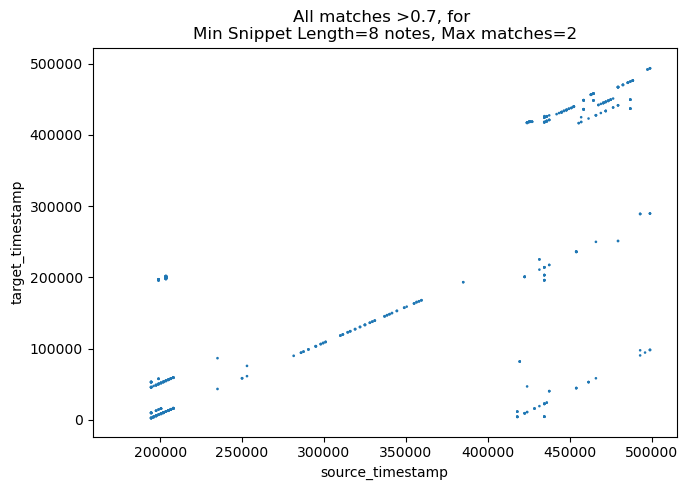

In [228]:
# plotting all mathes > threshold score

plt.rcParams["figure.figsize"] = [7, 5]
plt.rcParams["figure.autolayout"] = True

title = "All matches >"+str(thresh)+", for \nMin Snippet Length=" + str(minNotes) + " notes, Max matches=" + str(maxMatches)
simsDF.plot.scatter(x="source_timestamp", y="target_timestamp", s='score', title=title)


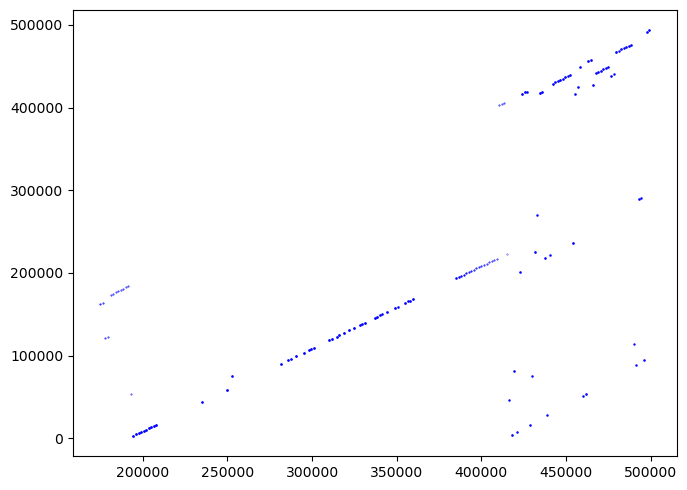

In [235]:
# Plotting best match only

plt.rcParams["figure.figsize"] = [7, 5]
plt.rcParams["figure.autolayout"] = True

count = 0
for x in range(minTime, notes[-1][0], 100):
    y = simsDFall.loc[simsDFall['source_timestamp'] == x]['score']
    if y.any(): 
        y = y.idxmax()
    else:
#         print("No match for",x)
        continue
    plt.scatter(simsDFall['source_timestamp'].loc[y],simsDFall['target_timestamp'].loc[y],simsDFall['score'].loc[y],c='blue')
    
plt.show()

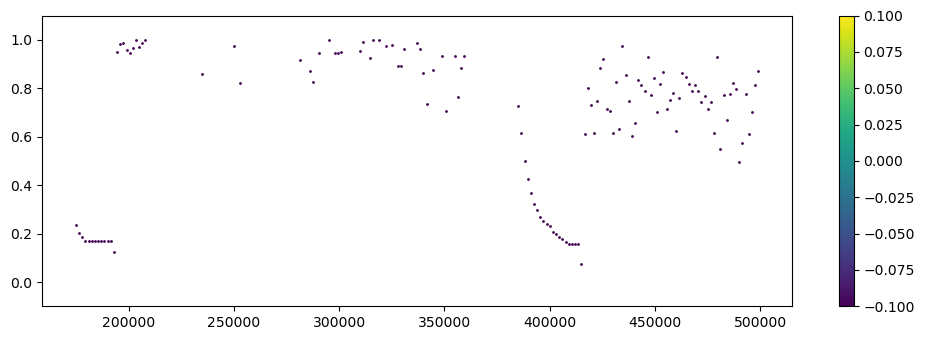

In [240]:
# Plotting best match score 

plt.rcParams["figure.figsize"] = [10, 3.50]
plt.rcParams["figure.autolayout"] = True

count = 0
for x in range(minTime, notes[-1][0], 500):
    y = simsDFall.loc[simsDFall['source_timestamp'] == x]['score'].max()
    s = simsDFall.loc[(simsDFall['source_timestamp'] == x) & (simsDFall['score'] == y)]['match_len'].max()
#     print(s)
    if math.isnan(y):
        count += 1
        y = 0
    plt.scatter(x,y,1,c=s,cmap='viridis') # need to include s (len of best match)
    
# print(count)
plt.ylim(-0.1, 1.1)
plt.colorbar()
plt.show()

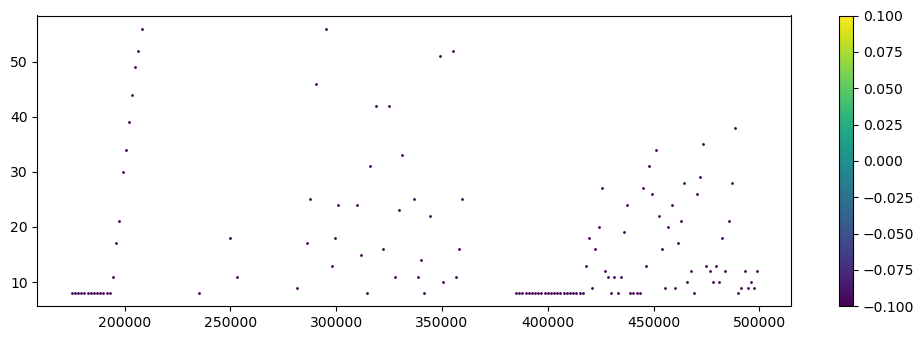

In [242]:
# Plotting note length of best match  

plt.rcParams["figure.figsize"] = [10, 3.50]
plt.rcParams["figure.autolayout"] = True

count = 0
for x in range(minTime, notes[-1][0], 500):
    y = simsDFall.loc[simsDFall['source_timestamp'] == x]['score'].max()
    s = simsDFall.loc[(simsDFall['source_timestamp'] == x) & (simsDFall['score'] == y)]['match_len'].max()
#     print(s)
    if math.isnan(y):
        count += 1
        y = 0
    plt.scatter(x,s,1,c=y,cmap='viridis') # need to include s (len of best match)
    
# print(count)
# plt.ylim(-0.1, 1.1)
plt.colorbar()
plt.show()

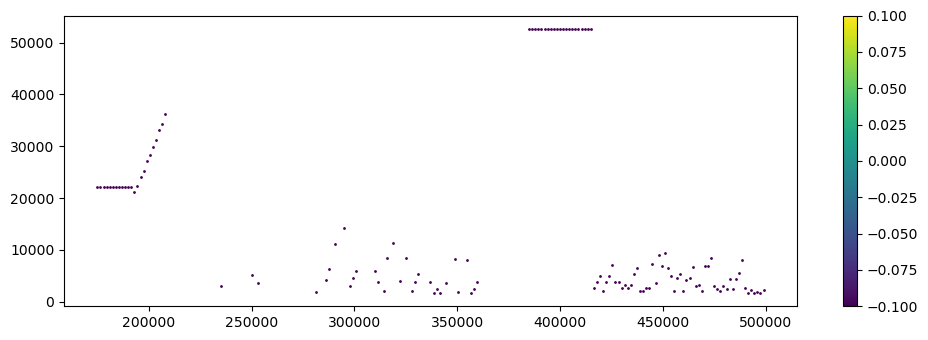

In [243]:
# Plotting time length of best match  

plt.rcParams["figure.figsize"] = [10, 3.50]
plt.rcParams["figure.autolayout"] = True

count = 0
for x in range(minTime, notes[-1][0], 500):
    y = simsDFall.loc[simsDFall['source_timestamp'] == x]['score'].max()
    s = simsDFall.loc[(simsDFall['source_timestamp'] == x) & (simsDFall['score'] == y)]['match_time'].max()
#     print(s)
    if math.isnan(y):
        count += 1
        y = 0
    plt.scatter(x,s,1,c=y,cmap='viridis') # need to include s (len of best match)
    
# print(count)
# plt.ylim(-0.1, 1.1)
plt.colorbar()
plt.show()